## DMD

For people already familiar with the method and interface, the [API docs](../api/generated/deeptime.decomposition.DMD.rst).

Here we present the basic ideas behind a family of dynamic mode decomposition (DMD) methods. In particular the original "standard DMD" <cite data-footcite="schmid2010dynamic">(Schmid, 2010)</cite>, its variant "exact DMD" <cite data-footcite="tu2013dynamic">(Tu, 2013)</cite>. The principle idea is that DMD should be able to characterize / decompose potentially highly nonlinear dynamics by solving linear systems of equations and studying their spectral properties.

Considering a sequential set of data vectors $\{z_1,\ldots,z_m\}$ with $z_i\in\mathbb{R}^n$ and assuming that 

$$ z_{k+1} = Az_k $$

for some usually unknown matrix $A$, one can define standard DMD as follows (following the presentation of <cite data-footcite="tu2013dynamic">(Tu, 2013)</cite>, originally introduced as DMD in <cite data-footcite="schmid2010dynamic">(Schmid, 2010)</cite> ).

1. The data is arranged into matrices $X, Y$ of matching pairs of time-shifted datapoints, i.e., $Y_{i+1} = X_{i}$ for $i \geq 1$.
2. Compute the (optionally truncated) SVD of $X$ to obtain $X = U\Sigma V^*$.
3. Define $\tilde{A} = U^*YV\Sigma^{-1}$.
4. Compute eigenvalues and eigenvectors $\tilde A w = \lambda w$.
5. The DMD mode corresponding to the DMD eigenvalue $\lambda$ is given by $\hat\varphi = Uw$.

It should be remarked that even if the data-generating dynamics are nonlinear, it is assumed that there exists some linear operator $A$ which approximates these.

The notion of "exact" DMD <cite data-footcite="tu2013dynamic">(Tu, 2013)</cite> weakens the assumptions and only requires that the data vectors are corresponding pairs of data. The operator $A$ is defined as the solution to the best-approximation of $\| AX - Y\|_F$.
This leads to exact DMD modes corresponding to eigenvalue $\lambda$ of the form

$$ \varphi = \frac{1}{\lambda}YV\Sigma^{-1}w. $$

Both estimation modes are united within the same estimator in Deeptime:

In [1]:
from deeptime.decomposition import DMD

standard_dmd = DMD(mode='standard')
exact_dmd = DMD(mode='exact')

The standard DMD is sometimes also referred to as projected DMD <cite data-footcite="tu2013dynamic">(Tu, 2013)</cite> since the modes $\hat\varphi$ are eigenvectors of $\mathbb{P}_XA$, where $\mathbb{P}_X = UU^*$ is the orthogonal projection onto the image of $X$. If data vectors $y_i$ are in the $\mathrm{span}\{x_i\}$, then $\mathbb{P}_X = \mathrm{Id}$; projected/standard and exact DMD modes coincide.

This can be especially relevant if there are more dimensions than datapoints.

We demonstrate the methods using a random orthogonal matrix $A$ which serves as out propagator plus some normal distributed noise, i.e.,

$$ x_{t+1} = Ax_t + \mathcal{N}(0, 10^{-4}). $$

In [2]:
import numpy as np

state = np.random.RandomState(45)

A = np.linalg.qr(state.normal(size=(2, 2)))[0]
x0 = state.uniform(-1, 1, size=(A.shape[0],))

data = np.empty((500, A.shape[0]))
data[0] = x0
for t in range(1, len(data)):
    data[t] = A @ data[t - 1] + state.normal(scale=1e-4, size=(2,))

Visualizing the generated data we can see that it is a jumping process between two wells.

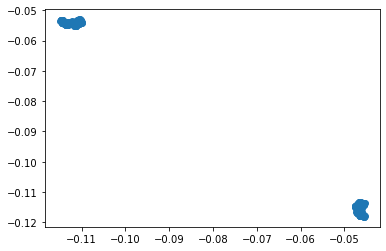

In [3]:
import matplotlib.pyplot as plt
plt.scatter(*data.T);

Fitting the models to this dataset reveals that the eigenvalues are identical:

In [4]:
standard_model = standard_dmd.fit((data[:-1], data[1:])).fetch_model()
exact_model = exact_dmd.fit((data[:-1], data[1:])).fetch_model()

In [5]:
print(f"Eigenvalues standard {standard_model.eigenvalues}, exact {exact_model.eigenvalues}")

Eigenvalues standard [ 1.00003048+0.j -1.00015445+0.j], exact [ 1.00003048+0.j -1.00015445+0.j]


We propagate the first ten datapoints using our estimated models:

In [6]:
traj_standard = standard_model.transform(data)
traj_exact = exact_model.transform(data)

A scatter plot reveals that all data points get mapped to the same two wells and the propagator was approximated almost perfectly.

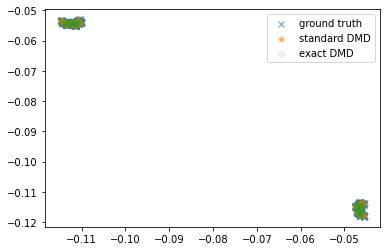

In [7]:
plt.scatter(*data.T, alpha=.5, marker='x', label='ground truth')
plt.scatter(*np.real(traj_standard)[::5].T, marker='*',alpha=.5, label='standard DMD')
plt.scatter(*np.real(traj_exact)[::5].T, alpha=.1, label='exact DMD')
plt.legend();